In [136]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import (accuracy_score, 
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             roc_auc_score, 
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             roc_curve,
                             auc)

from sklearn.neural_network import MLPClassifier

# Preprocessing

## Missing values

In [137]:
# Import adult data, 
data = pd.read_csv("raw_data/project_adult.csv", 
                   index_col=0, 
                   na_values="?") # Assign any instances of "?" to NA
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
5514,33,Local-gov,198183,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,>50K
19777,36,Private,86459,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,1887,50,United-States,>50K
10781,58,Self-emp-not-inc,203039,9th,5,Separated,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
32240,21,Private,180190,Assoc-voc,11,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,46,United-States,<=50K
9876,27,Private,279872,Some-college,10,Divorced,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [115]:
# Determine which columns have NA values
print(data.isna().sum())

age                  0
workclass         1447
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     458
income               0
dtype: int64


In [138]:
# Determine how significantly removing NA values would impact the dataset
print(f"Remaining data: {len(data.dropna()) / len(data) * 100:.2f}%")

Remaining data: 92.74%


In [139]:
# Impute NA values with the mode
for col in ['workclass', 'occupation', 'native-country']:
    data[col].fillna(data[col].mode()[0], inplace=True)

In [140]:
# Recheck for missing values
print(data.isna().sum())

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


# Modeling

In [141]:
# Split the dataset into features (X) and target (y) 
X = data.drop('income', axis=1)
y = data['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,      # 30-70 training-testing split
                                                    random_state=41103, # Random state for reproducibility
                                                    stratify=y)         # Stratify to ensure equal distribution of response classes



In [142]:
# Define categorical columns for training data
categorical = ['workclass', 'education', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'native-country']

numerical = ['age', 'fnlwgt', 'education-num', 'capital-gain',
             'capital-loss', 'hours-per-week']

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical)
    ]
)

## Baseline model

In [146]:
# Use default parameters for the baseline MLP
mlp_baseline = MLPClassifier(random_state=41103, max_iter=1000)

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('mlp', mlp_baseline)
])

pipe.fit(X_train, y_train)

y_pred_baseline = pipe.predict(X_test)
y_prob_baseline = pipe.predict_proba(X_test)[:, 1]

In [147]:
print("Test Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline))
print("Recall:", recall_score(y_test, y_pred_baseline))
print("F1 Score:", f1_score(y_test, y_pred_baseline))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_baseline))
print("\nClassification Report:\n", classification_report(y_test, y_pred_baseline))

Test Accuracy: 0.8316058861164427
Precision: 0.6546250684181719
Recall: 0.6358320042530569
F1 Score: 0.645091693635383
ROC-AUC: 0.764747818776343

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      5934
           1       0.65      0.64      0.65      1881

    accuracy                           0.83      7815
   macro avg       0.77      0.76      0.77      7815
weighted avg       0.83      0.83      0.83      7815



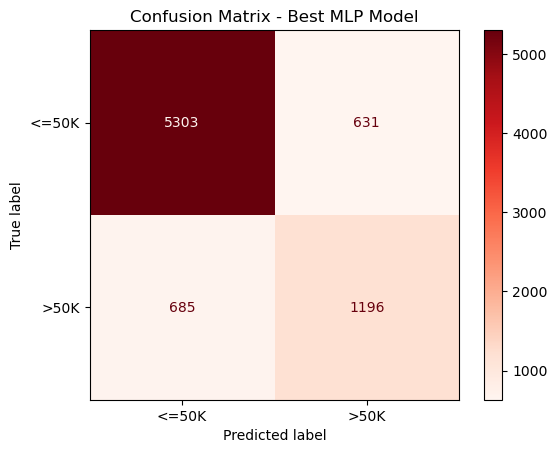

In [151]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

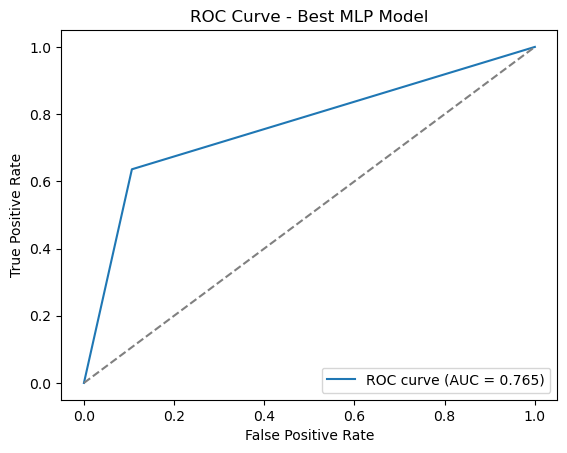

ROC-AUC Score: 0.7647


In [152]:
# Generate an ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_baseline)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best MLP Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_baseline):.4f}")

## Model refinement

In [ ]:
# Define MLP model
mlp = MLPClassifier(max_iter=1000, random_state=41103)

# Construct parameters for GridSearch to search over
param_grid = {
    # Try a small hidden layer, a larger hidden layer, and two hidden layers
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50)],
    
    # Try relu and tanh activatiion layers
    'mlp__activation': ['relu', 'tanh'],
    
    # Try Adam and Stochastic Gradient Descent solvers; both good for converging on larger datasets
    'mlp__solver': ['adam', 'sgd'],

    # Try small, midline, and large regularization values
    'mlp__alpha': [0.0001, 0.001, 0.01],

    # Try a conservative learning rate and an aggressive learning rate
    'mlp__learning_rate_init': [0.001, 0.01]
}

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('mlp', mlp)])

grid = GridSearchCV(pipe, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)

grid.fit(X_train, y_train)


In [153]:
print("Best parameters:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

Best parameters: {'mlp__activation': 'relu', 'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'sgd'}
Best cross-val accuracy: 0.8530684034074141


In [154]:
# Get the best model from GridSearch
best_model = grid.best_estimator_

# Get the best model's predictions 
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

Test Accuracy: 0.8541266794625719
Precision: 0.7235968617984309
Recall: 0.6374269005847953
F1 Score: 0.677784058790277
ROC-AUC: 0.7801222807608843

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.91      5934
           1       0.72      0.64      0.68      1881

    accuracy                           0.85      7815
   macro avg       0.81      0.78      0.79      7815
weighted avg       0.85      0.85      0.85      7815



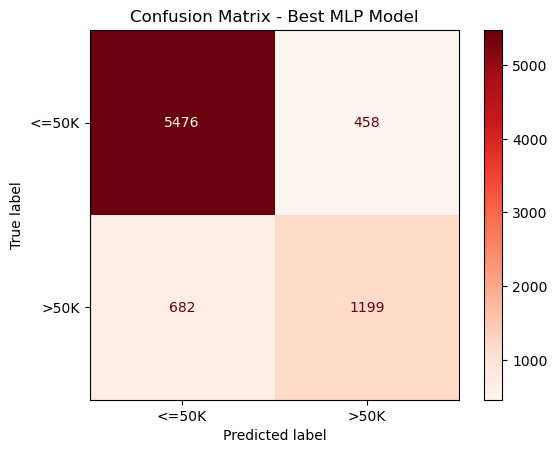

In [156]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Best MLP Model')
plt.show()

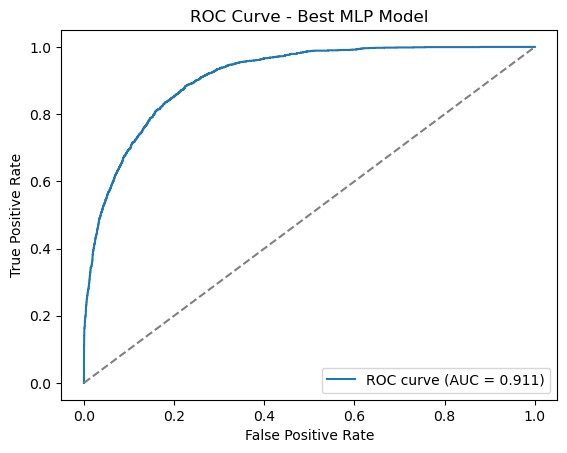

ROC-AUC Score: 0.9111


In [157]:
# Generate an ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_best)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Best MLP Model')
plt.legend(loc='lower right')
plt.show()

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob_best):.4f}")


## Output

# Testing

In [172]:
import numpy as np

# Load the validation dataset
validation_inputs = pd.read_csv("raw_data/project_validation_inputs.csv", index_col=0, na_values="?")

# Use the same preprocessing
for col in ['workclass', 'occupation', 'native-country']:
    validation_inputs[col].fillna(data[col].mode()[0], inplace=True)

# Predict using the best trained MLP model
validation_preds = best_model.predict(validation_inputs)

# Convert to DataFrame for export
validation_df = pd.DataFrame(validation_preds, columns=['Predicted'])

# Save predictions to CSV using required naming convention
validation_df.to_csv('Group_29_MLP_PredictedOutputs.csv', index=False)